In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from kaggle.api.kaggle_api_extended import KaggleApi

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

In [15]:
# --- 1. INGESTA AUTOMÁTICA ---
def get_data():
    api = KaggleApi()
    api.authenticate()
    # Descarga y descompresión
    api.dataset_download_files('zeeshier/weather-forecast-dataset', 
                        path=r'C:\Users\ACER\Documents\Proyectos TripleTen\AnalisisEstadisticos_Clas\files', unzip=True)
    # Nota: Ajusta el nombre del archivo según lo que contenga el zip, asumiremos 'weather.csv'
    # Si el nombre es distinto al descargar, cambiar aquí.
    try:
        df = pd.read_csv(r'C:\Users\ACER\Documents\Proyectos TripleTen\AnalisisEstadisticos_Clas\files\weather_forecast_data.csv') 
    except:
        # Fallback por si el nombre es distinto, busca cualquier csv
        import glob
        file = glob.glob(r'C:\Users\ACER\Documents\Proyectos TripleTen\AnalisisEstadisticos_Clas\files\*.csv')[0]
        df = pd.read_csv(file)
    return df

In [5]:
# --- 2. PREPROCESAMIENTO ---
def preprocess_data(df):
    # Asumimos que el target es 'Rain' o la última columna categórica.
    # Para este ejemplo, vamos a limpiar y codificar.
    
    df = df.dropna() # Para simplificar el ejemplo. En prod usaríamos Imputer.
    
    # Separar Target y Features
    # Ajusta 'Rain' al nombre real de la columna objetivo del dataset
    target_col = 'Rain' 
    
    # Codificar variables categóricas (Label Encoding)
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])
            
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Escalar datos (CRUCIAL para Lasso y ElasticNet)
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X_scaled, y, X.columns

In [6]:
# --- 3. MODELADO Y SELECCIÓN DE VARIABLES ---
def run_models(X, y, feature_names):
    results = {}
    models = {}
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    print("--- Entrenando Modelos ---")
    
    # A. Regresión Logística (Base)
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train)
    results['Logistic Regression'] = accuracy_score(y_test, log_reg.predict(X_test))
    models['Logistic Regression'] = log_reg

    # B. Selección Stepwise (Usando RFE - Recursive Feature Elimination)
    # Simulamos Stepwise seleccionando las 5 mejores características
    rfe = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=3)
    rfe.fit(X_train, y_train)
    results['Stepwise (RFE)'] = accuracy_score(y_test, rfe.predict(X_test))
    models['Stepwise (RFE)'] = rfe
    print(f"Variables Stepwise: {feature_names[rfe.support_]}")

    # C. LASSO (L1 Regularization)
    # C=inv de alpha. C pequeño = mucha regularización
    lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.5) 
    lasso.fit(X_train, y_train)
    results['Lasso (L1)'] = accuracy_score(y_test, lasso.predict(X_test))
    models['Lasso (L1)'] = lasso
    
    # D. Elastic Net (Mix L1 y L2)
    elastic = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=0.5, max_iter=2000)
    elastic.fit(X_train, y_train)
    results['Elastic Net'] = accuracy_score(y_test, elastic.predict(X_test))
    models['Elastic Net'] = elastic

    # E. Árbol de Decisión (Clasificación)
    tree = DecisionTreeClassifier(max_depth=5, random_state=42)
    tree.fit(X_train, y_train)
    results['Decision Tree'] = accuracy_score(y_test, tree.predict(X_test))
    models['Decision Tree'] = tree

    # F. Random Forest
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)
    results['Random Forest'] = accuracy_score(y_test, rf.predict(X_test))
    models['Random Forest'] = rf

    return results, models, X_test, y_test

In [18]:
# --- 4. VISUALIZACIÓN Y REPORTE ---
def visualize_results(results, models, X_test, y_test, feature_names):
    
    # Gráfico 1: Comparación de Precisión
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')
    plt.title('Comparación de Precisión (Accuracy) por Modelo')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(r'C:\Users\ACER\Documents\Proyectos TripleTen\AnalisisEstadisticos_Clas\files\model_comparison.png')
    plt.show()

    # Gráfico 2: Árbol del Mejor Modelo (o del Decision Tree explícito)
    # Visualizamos el Decision Tree para interpretar reglas de negocio
    plt.figure(figsize=(20, 10))
    plot_tree(models['Decision Tree'], feature_names=feature_names, filled=True, class_names=['No Rain', 'Rain'], fontsize=10)
    plt.title('Árbol de Decisión: Reglas de Predicción')
    plt.savefig(r'C:\Users\ACER\Documents\Proyectos TripleTen\AnalisisEstadisticos_Clas\files\decision_tree_viz.png')
    plt.show()
    
    print("\n--- Resultados Finales ---")
    for name, acc in results.items():
        print(f"{name}: {acc:.4f}")

Dataset URL: https://www.kaggle.com/datasets/zeeshier/weather-forecast-dataset
--- Entrenando Modelos ---
Variables Stepwise: Index(['Temperature', 'Humidity', 'Cloud_Cover'], dtype='object')


c:\Users\ACER\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\ACER\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
c:\Users\ACER\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2

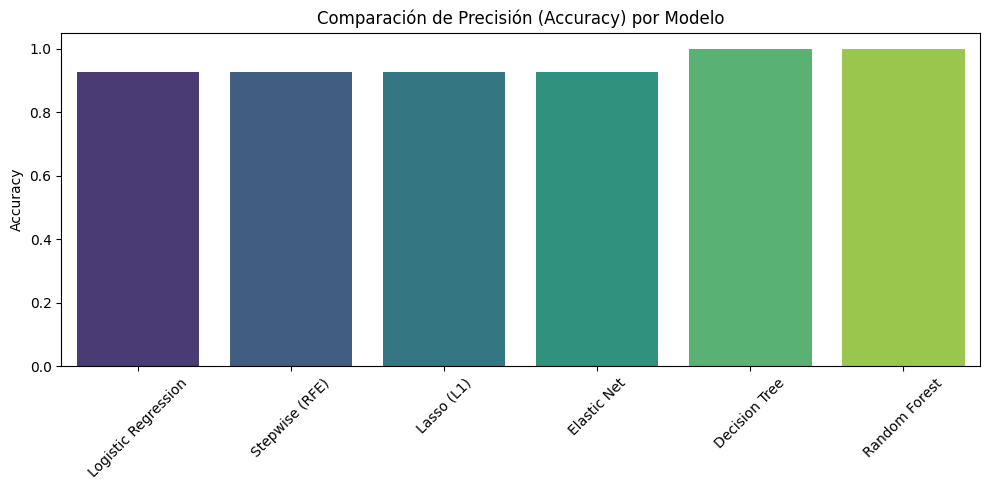

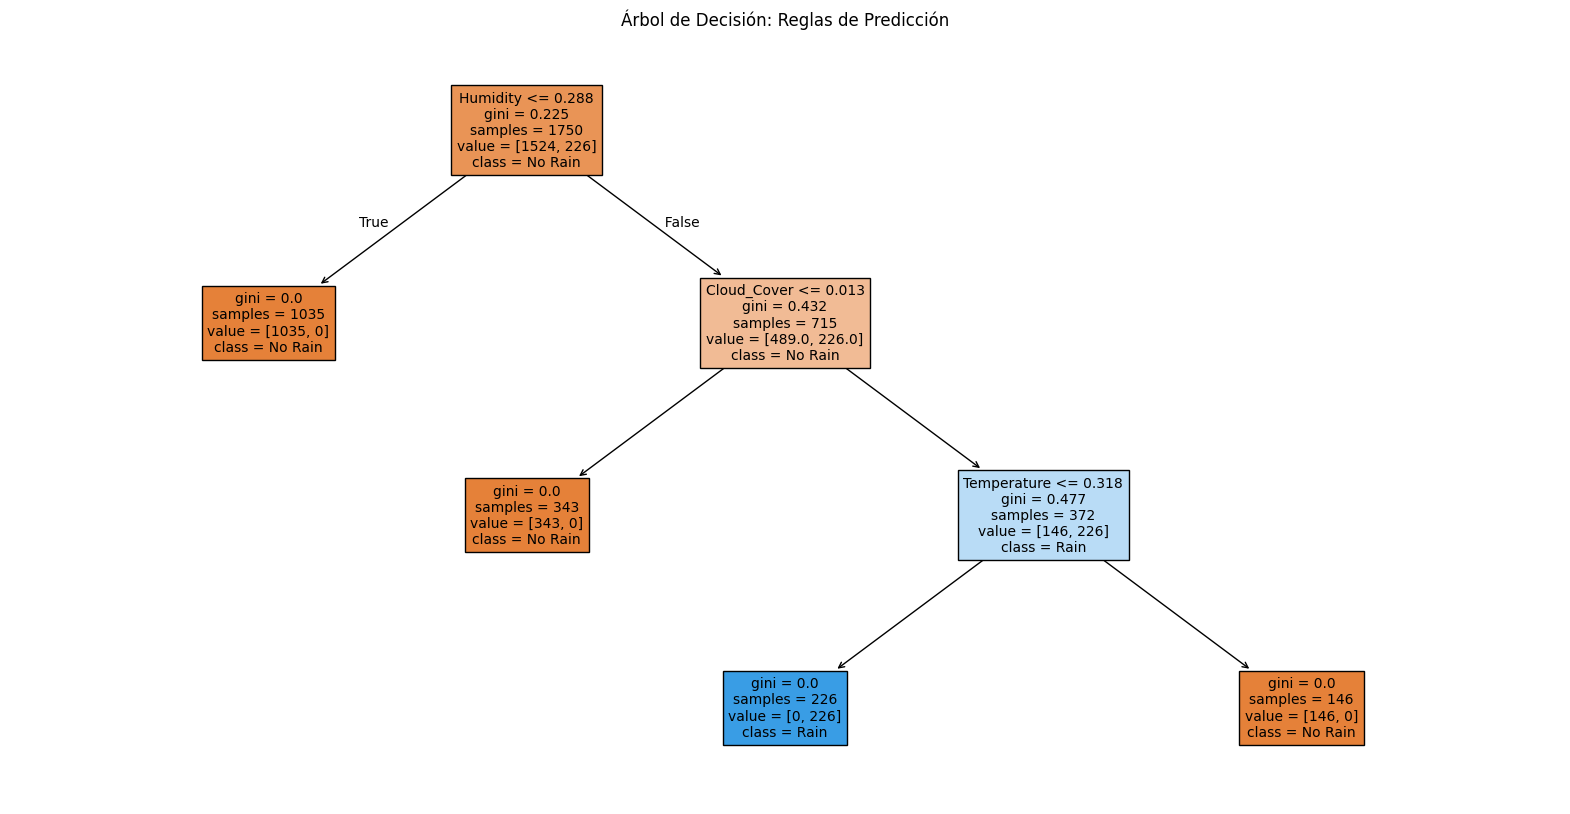


--- Resultados Finales ---
Logistic Regression: 0.9267
Stepwise (RFE): 0.9280
Lasso (L1): 0.9267
Elastic Net: 0.9280
Decision Tree: 1.0000
Random Forest: 0.9987


In [19]:
# --- MAIN ---
if __name__ == "__main__":
    df = get_data()
    
    # Pipeline
    X_scaled, y, feat_names = preprocess_data(df)
    results, trained_models, X_test, y_test = run_models(X_scaled, y, feat_names)
    visualize_results(results, trained_models, X_test, y_test, feat_names)